In [35]:
from matplotlib import pyplot as plt
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, MaxPooling1D, UpSampling1D
from keras.layers.convolutional import Conv1D, Conv2D
from keras.optimizers import SGD
import medleydb as mdb
from scipy import signal
from scipy.io import wavfile

In [4]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

# Load the audio data

In [5]:
multitracks = mdb.load_multitracks([
    "Phoenix_ColliersDaughter", 
    "Phoenix_BrokenPledgeChicagoReel", 
    "Phoenix_ElzicsFarewell", 
    "Phoenix_LarkOnTheStrandDrummondCastle",
    "Phoenix_ScotchMorris",
    "Phoenix_SeanCaughlinsTheScartaglen"
])

In [6]:
mix_audio = None
instrument_audio = None

for mix in multitracks:
    sample_rate, song = wavfile.read(mix.mix_path)
    
    if mix_audio is None:
        mix_audio = song
    
    else:
        mix_audio = np.concatenate((mix_audio, song))
    
    #
    
    instruments = mdb.get_files_for_instrument("violin", [mix])

    instrument = next(instruments)
    
    sample_rate, track = wavfile.read(instrument)
    
    if instrument_audio is None:
        instrument_audio = track
    
    else:
        instrument_audio = np.concatenate((instrument_audio, track))
    
mix_audio = mix_audio.mean(1)
instrument_audio = instrument_audio.mean(1)

In [7]:
samples_per_period = 256
overlap = int(samples_per_period/2)

# Process the Mix

In [8]:
freqs, times, s_mix = signal.stft(mix_audio, fs=sample_rate, nfft=samples_per_period, 
                                         noverlap=overlap, nperseg=samples_per_period)

freqs = freqs[:-1]
s_mix = s_mix[:-1,:]

In [9]:
#plt.pcolormesh(times, freqs, 20*np.log10(np.abs(s_mix)))
#plt.title("STFT of the Mix")
#plt.ylabel("Frequency (Hz)")
#plt.xlabel("Time (s)")

# Process the Target Instrument

In [10]:
freqs, times, s_instrument = signal.stft(instrument_audio, fs=sample_rate, nfft=samples_per_period, 
                                               noverlap=overlap, nperseg=samples_per_period)

s_instrument = s_instrument[:-1,:]

s_instrument += 1e-9

In [11]:
#plt.pcolormesh(times, freqs, 20*np.log10(np.abs(s_instrument)))
#plt.title("STFT of the instrument Track")
#plt.xlabel("Time (s)")
#plt.ylabel("Frequency (Hz)")

## Create a mask for the instrument

In [12]:
mask_instrument = s_instrument / (s_instrument + s_mix + 1e-9)

In [13]:
#plt.pcolormesh(times, freqs, 20*np.log10(np.abs(mask_instrument)))
#plt.title("Analytical Filter for the instrument Track")
#plt.xlabel("Time (s)")
#plt.ylabel("Frequency (Hz)")

# Prepare the training data

In [14]:
num_test  = int((sample_rate * 120)/samples_per_period)
num_train = s_mix.shape[1] - num_test
print(num_train, num_test)

374742 20671


In [15]:
mix_train = s_mix.T[:num_train,:,np.newaxis]
mix_train = np.concatenate((mix_train.real, mix_train.imag), axis=-1)
mix_train.shape

(374742, 128, 2)

In [16]:
#instrument_train = mask_instrument.T[:num_train,:,np.newaxis]
#instrument_train = np.concatenate((instrument_train.real, instrument_train.imag), axis=-1)
#instrument_train.shape

(374742, 128, 2)

In [51]:
instrument_train = s_instrument.T[:num_train,:,np.newaxis]
instrument_train = np.concatenate((instrument_train.real, instrument_train.imag), axis=-1)
instrument_train.shape

(374742, 128, 2)

In [52]:
mix_test = s_mix.T[-num_test:,:,np.newaxis]
mix_test = np.concatenate((mix_test.real, mix_test.imag), axis=-1)
mix_test.shape

(20671, 128, 2)

In [53]:
#instrument_test = mask_instrument.T[-num_test:,:,np.newaxis]
#instrument_test = np.concatenate((instrument_test.real, instrument_test.imag), axis=-1)
#instrument_test.shape

In [54]:
instrument_test = s_instrument.T[-num_test:,:,np.newaxis]
instrument_test = np.concatenate((instrument_test.real, instrument_test.imag), axis=-1)
instrument_test.shape

(20671, 128, 2)

In [63]:
model = Sequential()

model.add(Conv1D(16, 2, padding="same", input_shape=mix_train.shape[1:], activation="relu", name="Conv1D_1"))
model.add(MaxPooling1D(2, padding="same", name="MaxPooling_1"))

model.add(Conv1D(8, 2, padding="same",  activation="relu", name="Conv1D_2"))
model.add(MaxPooling1D(2, padding="same", name="MaxPooling_2"))

model.add(Conv1D(4, 2, padding="same",  activation="relu", name="Conv1D_3"))
model.add(MaxPooling1D(2, padding="same", name="MaxPooling_3"))

model.add(Conv1D(4, 2, padding="same",  activation="relu", name="Conv1D_4"))
model.add(UpSampling1D(2, name="UpSampling_1"))

model.add(Conv1D(8, 2, padding="same",  activation="relu", name="Conv1D_5"))
model.add(UpSampling1D(2, name="UpSampling_2"))

model.add(Conv1D(16, 2, padding="same",  activation="relu", name="Conv1D_6"))
model.add(UpSampling1D(2, name="UpSampling_3"))

model.add(Conv1D(2, 2, padding="same",  name="Conv1D_7"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 128, 16)           80        
_________________________________________________________________
MaxPooling_1 (MaxPooling1D)  (None, 64, 16)            0         
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 64, 8)             264       
_________________________________________________________________
MaxPooling_2 (MaxPooling1D)  (None, 32, 8)             0         
_________________________________________________________________
Conv1D_3 (Conv1D)            (None, 32, 4)             68        
_________________________________________________________________
MaxPooling_3 (MaxPooling1D)  (None, 16, 4)             0         
_________________________________________________________________
Conv1D_4 (Conv1D)            (None, 16, 4)             36        
__________

In [61]:
adam = Adam(lr=1e-3, beta_1=0.95, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

#sgd = SGD(lr=0.001, momentum=1.1, decay=1.1, nesterov=True)

model.compile(adam, loss='mean_squared_error', metrics=['accuracy'])

In [62]:
history = model.fit(mix_train, instrument_train, batch_size=1000, epochs=10)

Epoch 1/10
374742/374742 [==============================] - 22s 60us/step - loss: 1925.3438 - acc: 0.6508
Epoch 2/10
 86000/374742 [=====>........................] - ETA: 16s - loss: 1853.4030 - acc: 0.6484

KeyboardInterrupt: 

In [44]:
results = model.evaluate(mix_test, instrument_test)

print(model.metrics_names)
print(results)

20671/20671 [==============================] - 2s 73us/step
['loss', 'acc']
[1.8184278831581528, 0.784609174718013]


# Results

In [45]:
mask_prediction = model.predict(mix_test)
mask_prediction.shape

(20671, 128, 2)

In [46]:
mask_prediction = np.sqrt((mask_prediction**2).sum(-1)).T

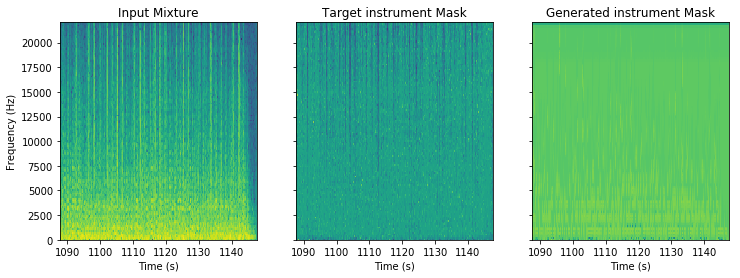

In [47]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,sharey=True,figsize=(12, 4))

ax1.set_title("Input Mixture")
ax2.set_title("Target instrument Mask")
ax3.set_title("Generated instrument Mask")

ax1.set_ylabel("Frequency (Hz)")
ax1.set_xlabel("Time (s)")
ax2.set_xlabel("Time (s)")
ax3.set_xlabel("Time (s)")

ax1.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(s_mix[:,-num_test:])))
ax2.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(mask_instrument[:,-num_test:])))
ax3.pcolormesh(times[-num_test:], freqs, 20*np.log10(mask_prediction))

In [48]:
target = s_mix[:,-num_test:] * mask_instrument[:,-num_test:]

In [49]:
prediction = s_mix[:,-num_test:] * mask_prediction

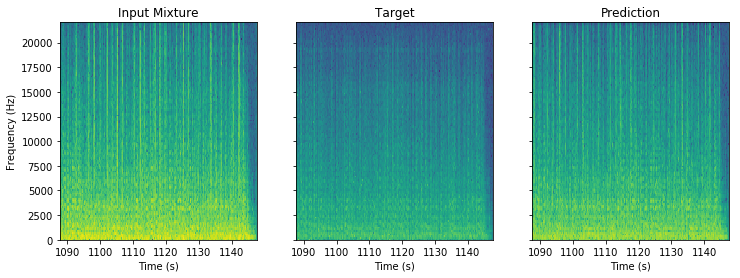

In [50]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(12, 4))

ax1.set_title("Input Mixture")
ax2.set_title("Target")
ax3.set_title("Prediction")

ax1.set_ylabel("Frequency (Hz)")
ax1.set_xlabel("Time (s)")
ax2.set_xlabel("Time (s)")
ax3.set_xlabel("Time (s)")

ax1.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(s_mix[:,-num_test:])))
ax2.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(target)))
ax3.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(prediction)))

## Let's hear it

In [30]:
_, predicted_audio = signal.istft(prediction, fs=sample_rate)

In [31]:
wavfile.write("fcn_model_instrument_prediction.wav", sample_rate, predicted_audio.astype(np.int16))

In [32]:
_, target_audio = signal.istft(target, fs=sample_rate)

In [33]:
wavfile.write("fcn_model_instrument_target.wav", sample_rate, target_audio.astype(np.int16))

In [34]:
_, mix_audio = signal.istft(s_mix[:,-num_test:], fs=sample_rate)

In [35]:
wavfile.write("fcn_model_original.wav", sample_rate, mix_audio.astype(np.int16))